In [202]:
import numpy as np
import pandas as pd
import pickle
#from build_database import flux_obj
from scipy import interpolate
import matplotlib.pyplot as plt
import os
import itertools
import random
import os
import time
import datetime as dt

from spacepy import coordinates as coord
from spacepy.time import Ticktock

from raytracer_utils import readdump, read_rayfile, read_rayfiles
from mpl_toolkits.mplot3d import Axes3D
#%matplotlib inline
%matplotlib nbagg
# Autoload changes made in external editor:
%load_ext autoreload
%autoreload 2
# --------------- Latex Plot Beautification --------------------------
fig_width_pt = 650.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean*1.5      # height in inches
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 14,
          'text.fontsize': 14,
          'legend.fontsize': 14,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


['qs', 'ms', 'nus', 'pos', 'n', 'stopcond', 'vprel', 'B0', 'damping', 'w', 'time', 'Nspec', 'Ns', 'vgrel']


<IPython.core.display.Javascript object>


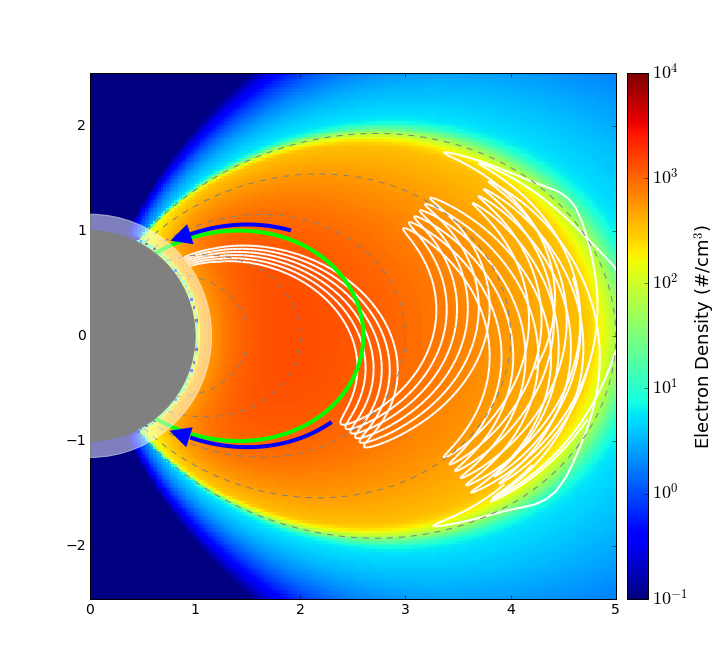

In [204]:
from matplotlib import collections  as mc
from mpl_toolkits.axes_grid1 import make_axes_locatable


# Load rayfile:
ray_root = '/shared/users/asousa/WIPP/lightning_power_study/rays/examples_for_ursi_plots/'
rayF = 200
lat_min = 35
lat_max = 40
lon_min = 0
lon_max = 0

flashtime = dt.datetime(2010, 8, 1, 0, 0, 0)
R_E = 6371e3 # Radius of earth in meters
H_IONO = 1000e3
D2R = (np.pi/180.0)

rf = read_rayfiles(ray_root,rayF,lat_min, lat_max, lon_min, lon_max)

# Convert to geographic coordinates for plotting:
rays = []
pwr  = []
print rf[0].keys()

D2R = np.pi/180.
L_shells = [1.5, 2, 3, 4, 5]
L_targ = [2.6]
# -------- 2D Plot -------------------
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_aspect("equal")
psize = 5


# Load the plasmasphere model (run it in the block below first)
from raytracer_utils import readdump
d = readdump('model_dump.dat')

Ne = d['Ns'][1,:,0,:].squeeze().T*1e-6  # m^3 -> cm^3
px = np.linspace(0,5, nx)
py = np.linspace(-2.5, 2.5, nz)
bg = ax.pcolormesh(px, py, np.log10(Ne),alpha=1)
clims = [-1, 4]
bg.set_clim(clims)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right",size="4%",pad=0.15)
cb = plt.colorbar(bg, cax=cax)
cb.set_label('Electron Density (#/cm$^3$)',fontsize=18)
cticks = np.arange(clims[0],clims[1] + 1)
cb.set_ticks(cticks)
cticklabels = ['$10^{%d}$'%k for k in cticks]
cb.set_ticklabels(cticklabels)
cb.ax.tick_params(labelsize=18)



# Plot the earth
earth = plt.Circle((0,0),1,color='0.5',alpha=1, zorder=100)
iono  = plt.Circle((0,0),(R_E + H_IONO)/R_E, color='w',alpha=0.5, zorder=99)
ax.add_patch(earth)                    # The earth (round)
ax.add_patch(iono)

# Plot the fieldlines
for L in L_shells:
    lam = np.linspace(-80,80,181)
    L_r = L*pow(np.cos(lam*D2R),2)
    Lx  = L_r*np.cos(lam*D2R)
    Ly  = L_r*np.sin(lam*D2R)
    ax.plot(Lx,Ly,color='grey',linewidth=1,linestyle='dashed')  # Field line

for L in L_targ:
    lam = np.linspace(-80,80,181)
    L_r = L*pow(np.cos(lam*D2R),2)
    Lx  = L_r*np.cos(lam*D2R)
    Ly  = L_r*np.sin(lam*D2R)
    ax.plot(Lx,Ly,color='#00ff00',linewidth=4)  # Field line
#     ax.plot(Lx,Ly,color='k',linewidth=1,zorder=98)  # Field line

# annotation arrows
for L in L_targ:
    lam = np.linspace(28, 45)
    L_r = (L+0.15)*pow(np.cos(lam*D2R),2)
    Lx  = L_r*np.cos(lam*D2R)
    Ly  = L_r*np.sin(lam*D2R)
    ax.plot(Lx,Ly,color='blue',linewidth=4)  # Field line
    ax.arrow(Lx[-1], Ly[-1], Lx[-1]-Lx[-2], Ly[-1] - Ly[-2],  head_width=0.2, head_length=0.2, fc='blue',linewidth=0, zorder=100)


    lam = np.linspace(-45, -20)
    L_r = (L+0.15)*pow(np.cos(lam*D2R),2)
    Lx  = L_r*np.cos(lam*D2R)
    Ly  = L_r*np.sin(lam*D2R)
    ax.plot(Lx,Ly,color='blue',linewidth=4)  # Field line

    ax.arrow(Lx[0], Ly[0], Lx[0]-Lx[1], Ly[0] - Ly[1],  head_width=0.2, head_length=0.2, fc='blue',linewidth=0, zorder=100)



for r in rf:

    tmp_coords = coord.Coords(zip(r['pos'].x, r['pos'].y, r['pos'].z),'SM','car',units=['m','m','m'])
    tvec_datetime = [flashtime + dt.timedelta(seconds=s) for s in r['time']]
    tmp_coords.ticks = Ticktock(tvec_datetime) # add ticks

    tmp_coords = tmp_coords.convert('MAG','car')
    tmp_coords.sim_time = r['time']

    tmp_coords.pwr = r['damping']

    rays.append(tmp_coords)


# Plot rays:
for r in rays:
#         ax.plot(np.sqrt(r.x*r.x + r.y*r.y)/R_E, r.z/R_E, linewidth=1, color='b')# marker='.')
#     # This block to map damping to color:
#     C = plt.cm.jet(r.pwr)
    points = np.array([np.sqrt(r.x*r.x + r.y*r.y)/R_E, r.z/R_E]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
#     lc = mc.LineCollection(segments, colors=C,alpha=0.5,linewidth=2)
    lc = mc.LineCollection(segments, alpha=1, color='w',linewidth=2)
    ax.add_collection(lc)



    ax.set_xlim([0, psize])
    ax.set_ylim([-psize/2.0, psize/2.0])


# ax.set_title('%d Hz'%rayF)
plt.savefig('LEP_process.png',ldpi=300)



/shared/users/asousa/software/raytracer_v1.17/bin/dumpmodel --minx=0 --maxx=3.1855e+07 --miny=0 --maxy=0 --minz=-1.59275e+07 --maxz=1.59275e+07 --nx=200 --ny=1 --nz=200 --filename=model_dump.dat --modelnum=1 --ngo_configfile=newray.in --use_igrf=1 --use_tsyganenko=0 --tsyganenko_Pdyn=0.5 --tsyganenko_Dst=0 --tsyganenko_ByIMF=0 --tsyganenko_BzIMF=0 --tsyganenko_W1=0 --tsyganenko_W2=0 --tsyganenko_W3=0 --tsyganenko_W4=0 --tsyganenko_W5=0 --tsyganenko_W6=0 


<IPython.core.display.Javascript object>


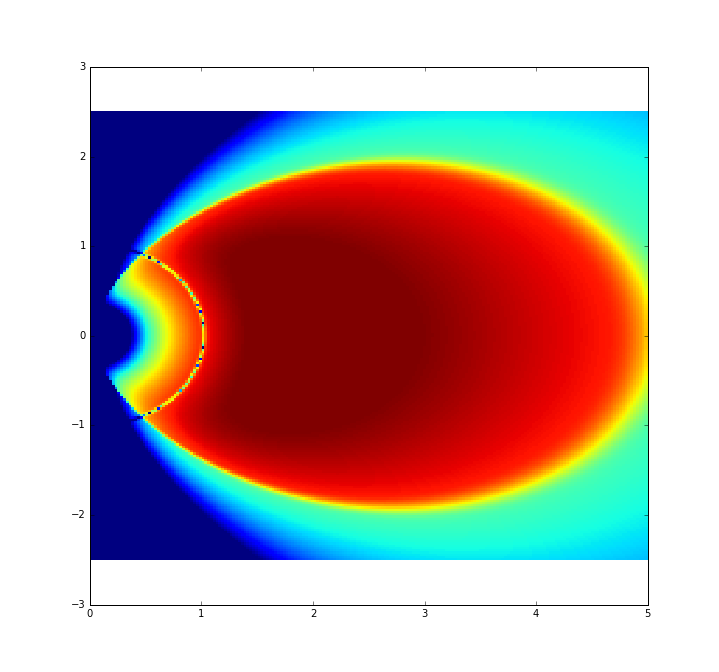

1365.37560198


In [162]:
# Get the field-line model

R_E = 6371e3
minx = 0
maxx = 5*R_E
miny = 0
maxy = 0
minz = -2.5*R_E
maxz = 2.5*R_E
nx = 200
nz = 200
root_cmd= '/shared/users/asousa/software/raytracer_v1.17/bin/dumpmodel'
cmd = '%s '%root_cmd +\
    '--minx=%g --maxx=%g '%(minx, maxx) +\
    '--miny=%g --maxy=%g '%(miny, maxy) +\
    '--minz=%g --maxz=%g '%(minz, maxz) +\
    '--nx=%g --ny=%g --nz=%g '%(nx, 1, nz) +\
    '--filename=%s '%('model_dump.dat') +\
    '--modelnum=%g '%(1) +\
    '--ngo_configfile=%s '%('newray.in') +\
    '--use_igrf=%g --use_tsyganenko=%g '%(1,0) +\
    '--tsyganenko_Pdyn=%g '%(0.5) +\
    '--tsyganenko_Dst=%g '%(0) +\
    '--tsyganenko_ByIMF=%g '%(0) +\
    '--tsyganenko_BzIMF=%g '%(0) +\
    '--tsyganenko_W1=%g '%(0) +\
    '--tsyganenko_W2=%g '%(0) +\
    '--tsyganenko_W3=%g '%(0) +\
    '--tsyganenko_W4=%g '%(0) +\
    '--tsyganenko_W5=%g '%(0) +\
    '--tsyganenko_W6=%g '%(0)
    
print cmd
os.system(cmd)


from raytracer_utils import readdump
d = readdump('model_dump.dat')


Ne = d['Ns'][1,:,0,:].squeeze().T*1e-6
Ne[np.isnan(Ne)] = 0
plt.figure()
px = np.linspace(0,5, nx)
py = np.linspace(-2.5, 2.5, nz)
# plt.imshow(np.log10(Ne), origin='lower',interpolation='None')
plt.pcolor(px,py,np.log10(Ne))
plt.clim([-1,3])
print np.max(Ne)

In [129]:
Ne[np.isnan(Ne)] = 0
print np.max(Ne)

1364926896.48
